In [13]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm, tqdm_notebook
import pandas as pd
import numpy as np
import gzip
import json
import math
from datetime import datetime
import seaborn as sns
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
%matplotlib inline
import pickle

import sys
sys.path.append('..')
from helper.rl_framework import *
from helper.orderbook_container import OrderbookContainer
from helper.manage_orderbooks import *
from helper.orderbook_trader import *
# from helper.RL_Agent import RLAgent
# from agents.NN_Agent import RLAgent_NN
from agents.BatchTree_Agent import RLAgent_BatchTree
from Runs.train_BatchTree import trainer
from Runs.train_fromSamples import train_BatchTree_fromSamples, train_Qtable_fromSamples

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
V=100
T=4
P=15

filename_train = '/home/axel/data/small/obs_2016-11_USDT_BTC_maxVol100.dict'

actions = list(np.linspace(-0.4, 1.0, num=15))
actions = range(-4,11)
print("Actions: ", ", ".join(["{:1.0f}".format(a) for a in actions]))

episodes_train = OrderbookEpisodesGenerator(filename=filename_train, episode_length=T*P)
print("Length of episodes_train: {}".format(len(episodes_train)))

Actions:  -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
Length of episodes_train: 541


### Settings

In [103]:
def load_and_preprocess_historyfiles(files):
    hist = pd.DataFrame()
    for file in histfiles:
        data = pd.read_csv(file, index_col=0)
        hist = pd.concat([hist, data])
    hist.set_index(keys=pd.to_datetime(hist.index), inplace=True)

    # remove dublicates and unneeded columns
    hist = hist[~hist.index.duplicated(keep='first')]
    hist.drop(["id", 'isFrozen'], axis=1, inplace=True)

    # fill gaps with last observation
    idx = pd.date_range(hist.index[0], hist.index[-1], freq="1min")
    hist = hist.sort_index().reindex(index=idx.sort_values(), method='ffill')
    
    # add more features
    hist['spread'] = hist.lowestAsk - hist.highestBid

    for lookahead in [15, 30, 45]:
        hist["future{}".format(lookahead)] = (hist['last'].shift(-lookahead) / hist['last']) - 1.

    return hist

histfiles = [
    "../../../../data/history/history_2016-11_USDT_BTC.csv",
    "../../../../data/history/history_2017-02_USDT_BTC.csv",
]

hist = load_and_preprocess_historyfiles(files=histfiles)
hist['future15_disc'] = pd.cut(hist.future15, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
hist['future30_disc'] = pd.cut(hist.future30, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
hist['future45_disc'] = pd.cut(hist.future45, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
hist['spread_disc'] = pd.cut(hist.spread, bins=[0, 1, 2, np.inf], labels=False)
display(hist.iloc[1021:1025,:])

,baseVolume,high24hr,highestBid,last,low24hr,lowestAsk,percentChange,quoteVolume,spread,future15,future30,future45,future15_disc,future30_disc,future45_disc,spread_disc
2016-11-09 03:01:00,417050.045093,716.0,709.740242,709.740241,702.680396,711.419498,0.004009,586.622061,1.679256,0.002366,0.004593,0.013399,3.0,3.0,4.0,1
2016-11-09 03:02:00,417128.134302,716.0,709.768994,711.419498,702.680396,711.419498,0.006251,586.731342,1.650504,0.002019,0.003802,0.008926,3.0,3.0,4.0,1
2016-11-09 03:03:00,417086.272705,716.0,709.723616,711.419498,702.680396,711.419498,0.006251,586.672174,1.695882,0.002019,0.003802,0.010514,3.0,3.0,4.0,1
2016-11-09 03:04:00,417050.431869,716.0,710.000001,710.000000,702.680396,711.419498,0.003144,586.621473,1.419497,0.003122,0.005845,0.013099,3.0,4.0,4.0,1


In [108]:
# cached_episodes = list(episodes_train[:20])
# pickle.dump( cached_episodes, open( "cached_episodes.p", "wb" ) )
data = pickle.load( open( "cached_windows/tradingwindows_1611_USTD_BTC_20.p", "rb" ) )
print(data[0][0].timestamp)
print(len(data))

# add features to orderbooks
for window in tqdm_notebook(data):
    for ob_idx, ob in enumerate(window):
        ob.features = {}
        ob.norm_factor = 1
        
        ob.features = {'spread': ob.asks.index[0]-ob.bids.index[0]}
        
        ts = pd.to_datetime(ob.timestamp)        
        ts_prev = pd.to_datetime(ob.timestamp) - pd.Timedelta('60Min')

        market_features = hist.loc[ts_prev:ts, :]
        for lookahead in [15,30,45]:
            ob.features["future{}".format(lookahead)] = market_features['future{}'.format(lookahead)][-1]
            ob.features["future{}_disc".format(lookahead)] = market_features['future{}_disc'.format(lookahead)][-1]
        ob.features['spread_disc'] = market_features['spread_disc'][-1]

2016-11-08T10:00
20


The installed widget Javascript is the wrong version.


In [109]:
data_feb = pickle.load( open( "cached_windows/tradingwindows_1702_USTD_BTC.p", "rb" ) )
print(data_feb[0][0].timestamp)
print(len(data_feb))

# add features to orderbooks
for window in tqdm_notebook(data_feb[:40]):
# for window in tqdm_notebook(data_feb[:100]):
    for ob_idx, ob in enumerate(window):
        ob.norm_factor = 1
        ob.features = {'spread': ob.asks.index[0]-ob.bids.index[0]}
        
        ts = pd.to_datetime(ob.timestamp)        
        ts_prev = pd.to_datetime(ob.timestamp) - pd.Timedelta('60Min')

        market_features = hist.loc[ts_prev:ts, :]
        
        for lookahead in [15,30,45]:
            ob.features["future{}".format(lookahead)] = market_features['future{}'.format(lookahead)][-1]
            ob.features["future{}_disc".format(lookahead)] = market_features['future{}_disc'.format(lookahead)][-1]
        ob.features['spread_disc'] = market_features['spread_disc'][-1]

2017-02-01T00:00
670


The installed widget Javascript is the wrong version.


In [6]:
data_selection = [data[x] for x in [0,17]]

In [115]:
T=4
P=15
V=70000
consume='cash'
actions = np.linspace(-0.4, 1.0, num=15)
#print("actions", actions, type(actions))

random.seed(13)
np.random.seed(13)
# plot_episode(episodes_train[1], volume=100)
data[0][0].timestamp
# actions = range(-4,11)
# agent = trainer(orderbooks=data, V=V, T=T, consume=consume, actions=actions,
#                 lim_stepsize=0.1, limit_base='incStepUnits',
#                 period_length=P, epochs=20, random_start=True,
#                 state_variables=['volume', 'time'])
# actions = range(-4,11)
# agent_noRand = trainer(orderbooks=data, V=V, T=T, consume=consume, actions=actions,
#                 lim_stepsize=0.1, limit_base='incStepUnits',
#                 period_length=P, epochs=20, random_start=False,
#                 state_variables=['volume', 'time'])

#actions = np.linspace(-0.4, 1.0, num=15)
#agent_aggFut15_noRand = trainer(orderbooks=data, V=V, T=T, consume=consume, actions=actions,
#                lim_stepsize=0.1, limit_base='agression',
#                period_length=P, epochs=20, random_start=False,
#                state_variables=['volume', 'time', 'future15'])

actions = np.linspace(-0.4, 1.0, num=15)
#agent_aggFut15disc_noRand
# agent = trainer(orderbooks=data[:20], V=V, T=T, consume=consume, actions=actions,
#                 lim_stepsize=0.1, limit_base='agression',
#                 period_length=P, epochs=1000, random_start=True,
#                 state_variables=['volume', 'time'])  # , 'future15_disc'])

# agent_small = trainer(orderbooks=data[:20], V=V, T=T, consume=consume, actions=actions,
#                 lim_stepsize=0.1, limit_base='agression',
#                 period_length=P, epochs=40, random_start=False,
#                 state_variables=['volume', 'time'])  # , 'future15_disc'])

agent_spread_rand = trainer(orderbooks=data[:20], V=V, T=T, consume=consume, actions=actions,
                lim_stepsize=0.1, limit_base='agression',
                period_length=P, epochs=100, random_start=True,
                state_variables=['volume', 'time', 'spread_disc'])

# actions = range(-4,11)
# agent_Fut15_noRand = trainer(orderbooks=data, V=V, T=T, consume=consume, actions=actions,
#                 lim_stepsize=0.1, limit_base='incStepUnits',
#                 period_length=P, epochs=20, random_start=False,
#                 state_variables=['volume', 'time', 'future15'])

# actions = np.linspace(-0.4, 1.0, num=15)
# agent_agg_noRand = trainer(orderbooks=data, V=V, T=T, consume=consume, actions=actions,
#                 lim_stepsize=0.1, limit_base='agression', #'incStepUnits',
#                 period_length=P, epochs=20, random_start=False,
#                 state_variables=['volume', 'time'])
# agent_agg.heatmap_Q(show_traces=True, which_min='first', show_minima_count=True)
#agent.heatmap_Q(show_traces=True, which_min='last', show_minima_count=True)

# agent153045 = trainer(orderbooks=data_selection, V=V, T=T, consume='cash', actions=actions,
#                 lim_stepsize=0.1, limit_base='incStepUnits',
#                 period_length=P, epochs=100, random_start=True,
#                 state_variables=['volume', 'time', 'future15', 'future30', 'future45'])

RL-Type: <class 'agents.BatchTree_Agent.RLAgent_BatchTree'>
Start parallel collection of samples in forward mode (num_cores=24)


100%|██████████| 100/100 [01:02<00:00,  1.78it/s]
[Parallel(n_jobs=24)]: Done  20 out of  20 | elapsed:  1.1min finished
 12%|█▎        | 1/8 [00:00<00:00,  9.63it/s]

brain.fitted_Q_iteration_tree()


100%|██████████| 8/8 [00:03<00:00,  2.53it/s]

brain.samples.shape (3033, 12)


In [10]:
agent_FW = train_BatchTree_fromSamples(agent.samples, V=70000, T=4, consume='cash', period_length=15,
                                   actions=actions, state_variables=['volume', 'time'], limit_base='agression')

  0%|          | 0/8 [00:00<?, ?it/s]

RL-Type: <class 'agents.BatchTree_Agent.RLAgent_BatchTree'>


100%|██████████| 8/8 [00:01<00:00,  4.94it/s]


In [104]:
def addMarketFeatures_toSamples(samples_df, hist, state_variables,
                                market_features, period_length=15):
    df = samples_df.copy()
    
    for i, f in tqdm(enumerate(market_features)):
        #
        f_n = "{}_n".format(f)
        if f in df.columns:
            df.drop(f, inplace=True, axis=1)
        if f_n in df.columns:
            df.drop(f_n, inplace=True, axis=1)
        
        df.insert(loc=2+i, column=f, value=df.timestamp.map(hist[f]),
                 allow_duplicates=True)
        df.insert(loc=df.shape[1],
                  column=f_n,
                  allow_duplicates=True,
                  value=(df.timestamp+pd.Timedelta(minutes=period_length)).map(hist[f]))
        if f not in state_variables:
            state_variables.append(f)

        if f in ['high24hr', 'low24hr', 'spread']:
            df[f] = df[f] / df.initial_center
            df[f_n] = df[f_n] / df.initial_center

    return df

df2 = addMarketFeatures_toSamples(samples_df=agent.samples, hist=hist, state_variables=['time', 'volume'],
                                 market_features=['future15', 'future15_disc', 'future30_disc', 'future45_disc', 'spread', 'spread_disc'])
print(df2.shape)
display(df2.describe())


0it [00:00, ?it/s]
1it [00:00,  1.76it/s]
2it [00:01,  1.76it/s]
3it [00:01,  1.78it/s]
6it [00:04,  1.43it/s]

(30946, 22)


,volume,time,future15,future15_disc,future30_disc,future45_disc,spread,spread_disc,action,action_idx,...,avg,initial_center,volume_n,time_n,future15_n,future15_disc_n,future30_disc_n,future45_disc_n,spread_n,spread_disc_n
count,30946.000000,30946.000000,30946.000000,30946.000000,30946.000000,30946.000000,3.094600e+04,30946.000000,30946.000000,30946.000000,...,30946.000000,30946.000000,30946.000000,30946.000000,30946.000000,30946.000000,30946.000000,30946.000000,3.094600e+04,30946.000000
mean,62657.251577,2.256221,0.000529,2.118949,2.200381,2.295482,1.710466e-03,0.692787,0.303910,7.039100,...,552.022700,711.903170,17417.155926,1.256221,0.000279,2.024656,2.184192,2.351548,1.738381e-03,0.708621
std,18481.278817,1.060939,0.002981,0.960240,1.006176,1.032672,1.186812e-03,0.747232,0.432167,4.321671,...,301.993122,4.969616,28237.201598,1.060939,0.003028,0.982414,0.975911,1.033335,1.164276e-03,0.728339
min,16.660000,1.000000,-0.005956,0.000000,0.000000,1.000000,3.508424e-10,0.000000,-0.400000,0.000000,...,0.000000,705.225474,0.000000,0.000000,-0.005956,0.000000,0.000000,1.000000,3.508424e-10,0.000000
25%,70000.000000,1.000000,-0.001733,1.000000,1.000000,1.000000,6.207705e-04,0.000000,-0.100000,3.000000,...,707.833110,709.266537,0.000000,0.000000,-0.001938,1.000000,1.000000,1.000000,6.207705e-04,0.000000
50%,70000.000000,2.000000,0.000420,2.000000,2.000000,2.000000,1.417209e-03,1.000000,0.300000,7.000000,...,714.536370,711.743188,0.000000,1.000000,0.000313,2.000000,2.000000,2.000000,1.547262e-03,1.000000
75%,70000.000000,3.000000,0.002366,3.000000,3.000000,3.000000,2.724130e-03,1.000000,0.700000,11.000000,...,717.257710,712.987654,28435.550000,2.000000,0.002307,3.000000,3.000000,3.000000,2.584346e-03,1.000000
max,70000.000000,4.000000,0.010030,4.000000,4.000000,4.000000,4.313834e-03,2.000000,1.000000,14.000000,...,742.339280,729.482963,70000.000000,3.000000,0.010030,4.000000,4.000000,4.000000,4.307581e-03,2.000000


In [105]:
# agent_BW = train_Qtable_fromSamples(df2, V=70000, T=4, consume='cash', period_length=15,
#                                    vol_intervals=10, actions=[round(a,2) for a in actions],
#                                    state_variables=['volume', 'time', 'future15_disc'], limit_base='agression')
# 
agent_BW_spread = train_Qtable_fromSamples(df2, V=70000, T=4, consume='cash', period_length=15,
                                   vol_intervals=10, actions=[round(a,2) for a in actions],
                                   state_variables=['volume', 'time', 'spread_disc'], limit_base='agression')

  0%|          | 0/4 [00:00<?, ?it/s]

RL-Type: <class 'agents.QTable_Agent.QTable_Agent'>


,volume,time,future15,future15_disc,future30_disc,future45_disc,spread,spread_disc,action,action_idx,...,initial_center,timestamp,volume_n,time_n,future15_n,future15_disc_n,future30_disc_n,future45_disc_n,spread_n,spread_disc_n
2,70000.0,1.0,0.001341,3.0,3.0,3.0,0.00019,0,0.4,8,...,705.225474,2016-11-08 10:45:00,0.0,0.0,0.00073,2.0,2.0,3.0,0.002131,1
4,70000.0,1.0,0.001341,3.0,3.0,3.0,0.00019,0,-0.3,1,...,705.225474,2016-11-08 10:45:00,0.0,0.0,0.00073,2.0,2.0,3.0,0.002131,1
7,70000.0,1.0,0.001341,3.0,3.0,3.0,0.00019,0,-0.2,2,...,705.225474,2016-11-08 10:45:00,0.0,0.0,0.00073,2.0,2.0,3.0,0.002131,1
12,70000.0,1.0,0.001341,3.0,3.0,3.0,0.00019,0,-0.2,2,...,705.225474,2016-11-08 10:45:00,0.0,0.0,0.00073,2.0,2.0,3.0,0.002131,1
16,70000.0,1.0,0.001341,3.0,3.0,3.0,0.00019,0,-0.3,1,...,705.225474,2016-11-08 10:45:00,0.0,0.0,0.00073,2.0,2.0,3.0,0.002131,1


 25%|██▌       | 1/4 [00:23<01:11, 23.76s/it]

,volume,time,future15,future15_disc,future30_disc,future45_disc,spread,spread_disc,action,action_idx,...,initial_center,timestamp,volume_n,time_n,future15_n,future15_disc_n,future30_disc_n,future45_disc_n,spread_n,spread_disc_n
0,70000.0,2.0,-0.001938,1.0,2.0,2.0,0.001435,1,0.7,11,...,705.225474,2016-11-08 10:30:00,0.0,1.0,0.001341,3.0,3.0,3.0,0.00019,0
1,70000.0,2.0,-0.001938,1.0,2.0,2.0,0.001435,1,-0.2,2,...,705.225474,2016-11-08 10:30:00,70000.0,1.0,0.001341,3.0,3.0,3.0,0.00019,0
3,70000.0,2.0,-0.001938,1.0,2.0,2.0,0.001435,1,-0.3,1,...,705.225474,2016-11-08 10:30:00,70000.0,1.0,0.001341,3.0,3.0,3.0,0.00019,0
6,70000.0,2.0,-0.001938,1.0,2.0,2.0,0.001435,1,0.9,13,...,705.225474,2016-11-08 10:30:00,0.0,1.0,0.001341,3.0,3.0,3.0,0.00019,0
8,70000.0,2.0,-0.001938,1.0,2.0,2.0,0.001435,1,1.0,14,...,705.225474,2016-11-08 10:30:00,0.0,1.0,0.001341,3.0,3.0,3.0,0.00019,0


 50%|█████     | 2/4 [00:43<00:44, 22.50s/it]

,volume,time,future15,future15_disc,future30_disc,future45_disc,spread,spread_disc,action,action_idx,...,initial_center,timestamp,volume_n,time_n,future15_n,future15_disc_n,future30_disc_n,future45_disc_n,spread_n,spread_disc_n
5,70000.0,3.0,-0.000639,2.0,1.0,1.0,0.002057,1,0.9,13,...,705.225474,2016-11-08 10:15:00,0.0,2.0,-0.001938,1.0,2.0,2.0,0.001435,1
9,70000.0,3.0,-0.000639,2.0,1.0,1.0,0.002057,1,0.9,13,...,705.225474,2016-11-08 10:15:00,0.0,2.0,-0.001938,1.0,2.0,2.0,0.001435,1
11,70000.0,3.0,-0.000639,2.0,1.0,1.0,0.002057,1,0.7,11,...,705.225474,2016-11-08 10:15:00,0.0,2.0,-0.001938,1.0,2.0,2.0,0.001435,1
15,70000.0,3.0,-0.000639,2.0,1.0,1.0,0.002057,1,0.2,6,...,705.225474,2016-11-08 10:15:00,0.0,2.0,-0.001938,1.0,2.0,2.0,0.001435,1
17,70000.0,3.0,-0.000639,2.0,1.0,1.0,0.002057,1,0.6,10,...,705.225474,2016-11-08 10:15:00,0.0,2.0,-0.001938,1.0,2.0,2.0,0.001435,1


 75%|███████▌  | 3/4 [00:59<00:20, 20.69s/it]

,volume,time,future15,future15_disc,future30_disc,future45_disc,spread,spread_disc,action,action_idx,...,initial_center,timestamp,volume_n,time_n,future15_n,future15_disc_n,future30_disc_n,future45_disc_n,spread_n,spread_disc_n
13,70000.0,4.0,-3.246150e-08,2.0,2.0,1.0,0.00064,0,1.0,14,...,705.225474,2016-11-08 10:00:00,0.0,3.0,-0.000639,2.0,1.0,1.0,0.002057,1
14,70000.0,4.0,-3.246150e-08,2.0,2.0,1.0,0.00064,0,-0.0,4,...,705.225474,2016-11-08 10:00:00,70000.0,3.0,-0.000639,2.0,1.0,1.0,0.002057,1
20,70000.0,4.0,-3.246150e-08,2.0,2.0,1.0,0.00064,0,0.8,12,...,705.225474,2016-11-08 10:00:00,0.0,3.0,-0.000639,2.0,1.0,1.0,0.002057,1
21,70000.0,4.0,-3.246150e-08,2.0,2.0,1.0,0.00064,0,0.6,10,...,705.225474,2016-11-08 10:00:00,0.0,3.0,-0.000639,2.0,1.0,1.0,0.002057,1
23,70000.0,4.0,-3.246150e-08,2.0,2.0,1.0,0.00064,0,0.8,12,...,705.225474,2016-11-08 10:00:00,0.0,3.0,-0.000639,2.0,1.0,1.0,0.002057,1


100%|██████████| 4/4 [01:10<00:00, 17.70s/it]


In [80]:
print(len(agent_BW.q.keys()))
for elem in agent_BW.q.keys():
    print(elem)

32
[1.0, 0.25]
[0.0, 0.25]
[0.1, 0.25]
[0.8, 0.25]
[0.6, 0.25]
[0.2, 0.25]
[0.4, 0.25]
[0.5, 0.25]
[0.3, 0.25]
[0.7, 0.25]
[0.9, 0.25]
[1.0, 0.5]
[0.1, 0.5]
[0.0, 0.5]
[0.6, 0.5]
[0.2, 0.5]
[0.3, 0.5]
[0.5, 0.5]
[0.8, 0.5]
[0.7, 0.5]
[0.4, 0.5]
[1.0, 0.75]
[0.1, 0.75]
[0.2, 0.75]
[0.3, 0.75]
[0.6, 0.75]
[0.5, 0.75]
[0.7, 0.75]
[0.0, 0.75]
[0.4, 0.75]
[0.8, 0.75]
[1.0, 1.0]


Start parallel evalutions of strategies. (num_cores=24)


[Parallel(n_jobs=24)]: Done   3 out of  20 | elapsed:    8.7s remaining:   49.2s
[Parallel(n_jobs=24)]: Done   8 out of  20 | elapsed:   12.5s remaining:   18.8s
[Parallel(n_jobs=24)]: Done  13 out of  20 | elapsed:   13.5s remaining:    7.3s
[Parallel(n_jobs=24)]: Done  18 out of  20 | elapsed:   18.2s remaining:    2.0s
[Parallel(n_jobs=24)]: Done  20 out of  20 | elapsed:   21.4s finished


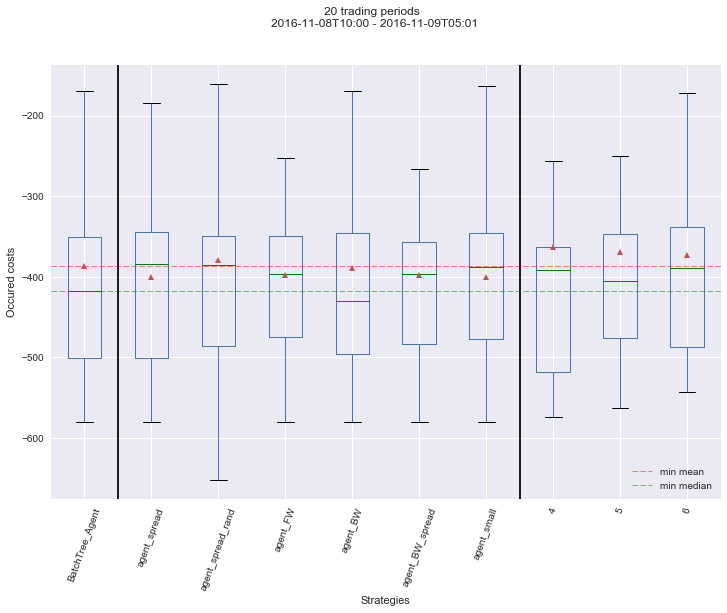

,BatchTree_Agent,agent_spread,agent_spread_rand,agent_FW,agent_BW,agent_BW_spread,agent_small,4,5,6
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,-386.350929,-400.766037,-378.641591,-397.735708,-388.793304,-397.328510,-400.825551,-363.234907,-369.858969,-373.524334
std,230.585128,153.330364,161.154627,173.995921,212.399786,171.452404,163.585972,343.816241,295.850419,241.321635
min,-782.207690,-782.207690,-651.793633,-782.207690,-782.207690,-782.207690,-782.207690,-901.858014,-885.576695,-797.701693
25%,-500.366385,-500.387592,-486.262645,-474.176231,-496.097049,-483.714100,-477.320148,-518.123757,-476.083783,-486.804137
50%,-418.130429,-384.519145,-385.205212,-396.963596,-429.649033,-396.085030,-387.495058,-391.911993,-405.042913,-388.968061
75%,-350.365934,-344.842289,-349.974142,-348.812661,-346.283964,-356.723207,-346.226234,-363.005432,-346.535131,-338.182773
max,388.521290,-46.276431,-13.025741,92.295748,244.672600,-11.506499,17.684629,916.121225,719.040014,487.631406
rel_mean,1.000000,1.037311,0.980046,1.029467,1.006322,1.028413,1.037465,0.940168,0.957314,0.966801
rel_median,1.000000,0.919615,0.921256,0.949377,1.027548,0.947276,0.926733,0.937296,0.968700,0.930255


In [116]:
costs = None
costs = agent.evaluate(
    testdata=data[:20],
    additional_agents={
        'agent_spread': agent_spread,
        'agent_spread_rand': agent_spread_rand,
        'agent_FW': agent_FW,
        'agent_BW': agent_BW,
        'agent_BW_spread': agent_BW_spread,
        'agent_small': agent_small,
       # 'agent_noRand': agent_noRand,
       # 'agent_agg': agent_agg,
       # 'agent_agg_noRand': agent_agg_noRand,
       # 'agent_agg_noRand_fake': agent_agg_noRand,
       # 'agent_aggFut15': agent_aggFut15, 
       # 'agent_aggFut15_noRand': agent_aggFut15_noRand,
       # 'agent_aggFut15disc_noRand': agent_aggFut15disc_noRand,
       # 'agent_agg100': agent_agg100,
       # 'agent_Fut15_noRand': agent_Fut15_noRand,
       # 'agent_Fut15': agent_Fut15,
    },
    evaluate_actions=[4, 5, 6],
    costs=costs,
    verbose=False,
    show_plot=True)
#display(costs)
#display(costs.mean())

In [118]:
print(agent_spread.samples.shape)
print(agent_spread_rand.samples.shape)

(3043, 12)
(3033, 12)


Start parallel evalutions of strategies. (num_cores=24)
No Q-table entry found for state '[0.4, 0.75, 2]'
No Q-table entry found for state '[0.4, 0.75, 1.0]'
No Q-table entry found for state '[0.8, 0.75, 3.0]'
No Q-table entry found for state '[0.6, 0.75, 1.0]'
No Q-table entry found for state '[0.8, 0.5, 0.0]'
No Q-table entry found for state '[0.5, 0.5, 2.0]'


[Parallel(n_jobs=24)]: Done   3 out of  20 | elapsed:    9.3s remaining:   52.5s


No Q-table entry found for state '[0.8, 0.75, 0.0]'
No Q-table entry found for state '[0.9, 0.75, 3.0]'
No Q-table entry found for state '[0.8, 0.75, 1.0]'
No Q-table entry found for state '[0.5, 0.75, 0]'
No Q-table entry found for state '[0.9, 0.5, 1]'
No Q-table entry found for state '[0.9, 0.5, 2.0]'
No Q-table entry found for state '[0.8, 0.5, 2.0]'
No Q-table entry found for state '[0.8, 0.75, 2]'
No Q-table entry found for state '[0.5, 0.75, 1.0]'
No Q-table entry found for state '[0.9, 0.25, 1]'
No Q-table entry found for state '[0.5, 0.75, 0]'
No Q-table entry found for state '[0.3, 0.5, 0.0]'
No Q-table entry found for state '[0.8, 0.25, 1]'
No Q-table entry found for state '[0.9, 0.75, 2]'
No Q-table entry found for state '[0.9, 0.5, 0]'
No Q-table entry found for state '[0.9, 0.25, 2]'
No Q-table entry found for state '[0.5, 0.75, 2]'
No Q-table entry found for state '[0.8, 0.75, 3.0]'
No Q-table entry found for state '[0.8, 0.5, 2.0]'


[Parallel(n_jobs=24)]: Done   8 out of  20 | elapsed:   14.0s remaining:   21.1s
[Parallel(n_jobs=24)]: Done  13 out of  20 | elapsed:   15.4s remaining:    8.3s
[Parallel(n_jobs=24)]: Done  18 out of  20 | elapsed:   16.5s remaining:    1.8s
[Parallel(n_jobs=24)]: Done  20 out of  20 | elapsed:   18.8s finished


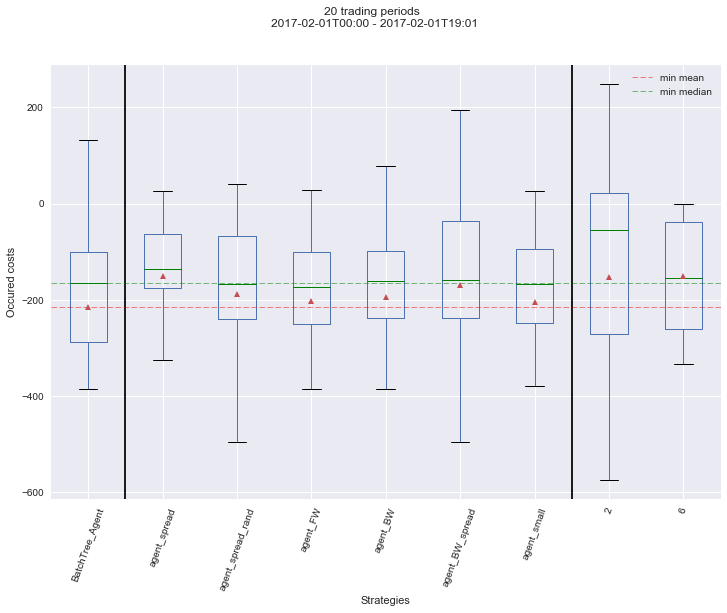

,BatchTree_Agent,agent_spread,agent_spread_rand,agent_FW,agent_BW,agent_BW_spread,agent_small,2,6
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,-214.112028,-151.186693,-188.328773,-202.340144,-194.773291,-169.882991,-203.401744,-151.955321,-149.547773
std,203.886996,146.916716,216.368201,172.599502,198.016968,209.409457,173.974972,277.293440,116.436838
min,-629.062617,-629.062617,-643.297436,-629.062617,-629.062617,-629.062617,-629.062617,-773.588111,-333.328762
25%,-286.799582,-174.949487,-239.579401,-249.575830,-238.085881,-236.695358,-247.738496,-270.508641,-260.184943
50%,-164.281919,-135.413971,-167.060261,-173.752861,-159.868176,-159.646741,-165.984489,-54.244725,-153.801504
75%,-100.713889,-62.112742,-67.175153,-100.711631,-97.363212,-36.671650,-94.987039,22.194543,-37.067614
max,131.882682,27.144498,222.139230,28.228168,134.830749,193.814877,26.311714,247.933014,0.000000
rel_mean,1.000000,0.706110,0.879581,0.945020,0.909679,0.793430,0.949978,0.709700,0.698456
rel_median,1.000000,0.824278,1.016912,1.057651,0.973133,0.971785,1.010364,0.330193,0.936205


BatchTree_Agent     -214.112028
agent_spread        -151.186693
agent_spread_rand   -188.328773
agent_FW            -202.340144
agent_BW            -194.773291
agent_BW_spread     -169.882991
agent_small         -203.401744
2                   -151.955321
6                   -149.547773
dtype: float64

In [119]:
costs = None
costs = agent.evaluate(
    testdata=data_feb[:20],
    additional_agents={
        'agent_spread': agent_spread,
        'agent_spread_rand': agent_spread_rand,
        'agent_FW': agent_FW,
        'agent_BW': agent_BW,
        'agent_BW_spread': agent_BW_spread,
        'agent_small': agent_small,
       # 'agent_noRand': agent_noRand,
       # 'agent_agg': agent_agg,
       # 'agent_agg_noRand': agent_agg_noRand,
       # 'agent_agg_noRand_fake': agent_agg_noRand,
       # 'agent_aggFut15': agent_aggFut15, 
       # 'agent_aggFut15_noRand': agent_aggFut15_noRand,
       # 'agent_aggFut15disc_noRand': agent_aggFut15disc_noRand,
       # 'agent_agg100': agent_agg100,
       # 'agent_Fut15_noRand': agent_Fut15_noRand,
       # 'agent_Fut15': agent_Fut15,
    },
    evaluate_actions=[2, 6],
    costs=costs,
    verbose=False,
    show_plot=True)
# display(costs)
display(costs.mean())